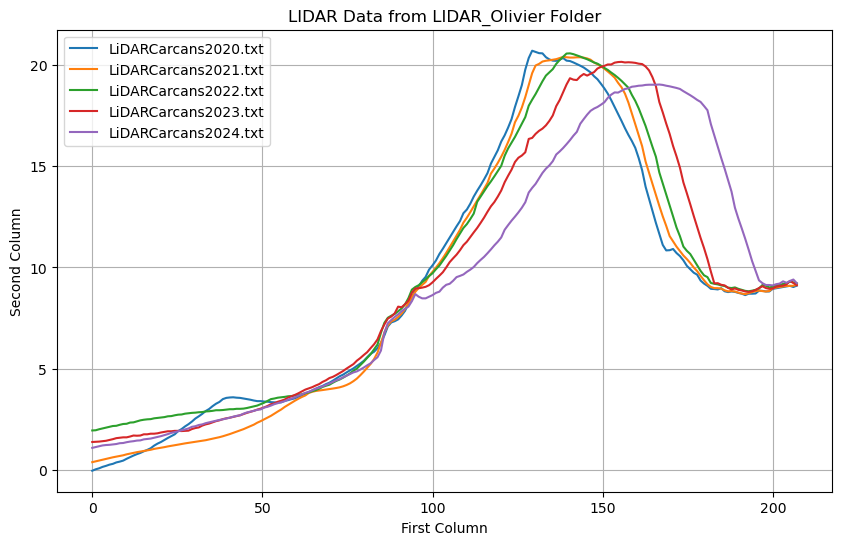

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt

# Get all files in the LIDAR_Olivier folder
folder_path = 'LIDAR_Olivier'
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Create a single figure
plt.figure(figsize=(10, 6))

# Read and plot each file
for file in files:
    file_path = os.path.join(folder_path, file)
    try:
        # Read the file (assuming it's a text file with columns)
        data = pd.read_csv(file_path, sep=r'\s+', header=None)
        # Plot first column (x-axis) vs second column (y-axis)
        plt.plot(data[0], data[1], label=file)
    except Exception as e:
        print(f"Error reading {file}: {e}")

plt.xlabel('First Column')
plt.ylabel('Second Column')
plt.title('LIDAR Data from LIDAR_Olivier Folder')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\svries\AppData\Local\Temp\ipykernel_24940\2112871942.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


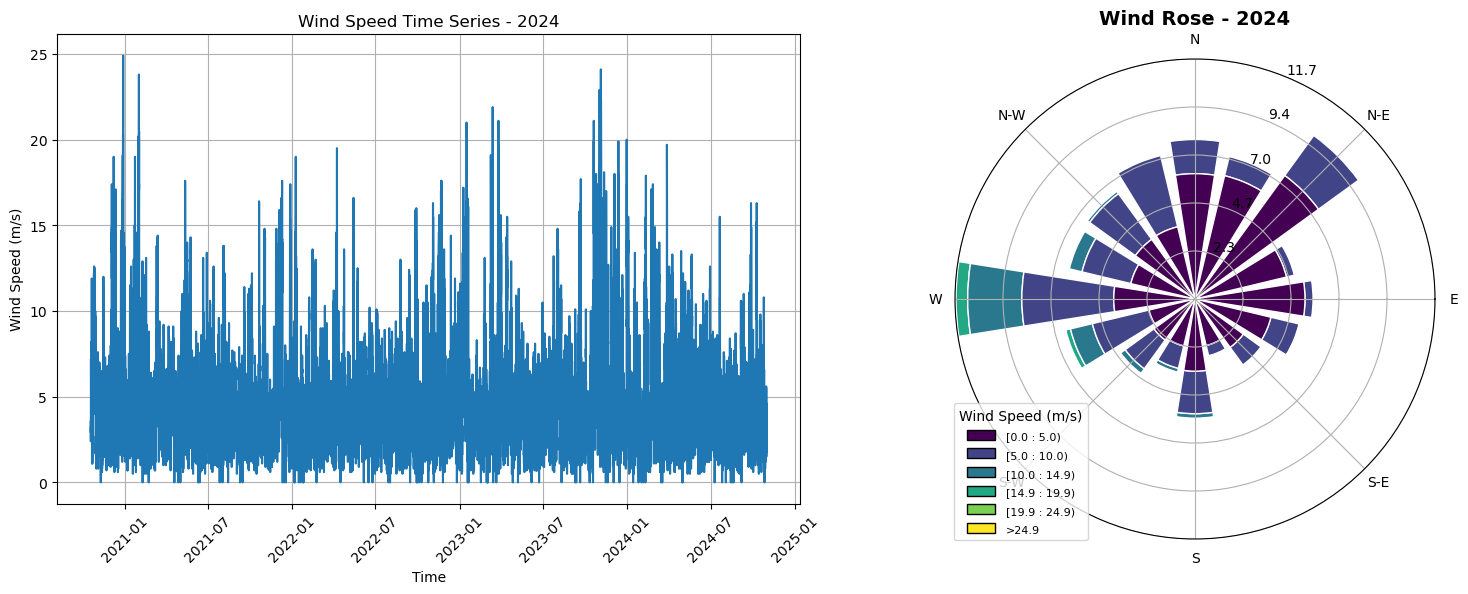

In [2]:
# Read wind data from Wind_Jules folder
wind_file = 'Wind_Jules/wind_CF_MF_2024.csv'
wind_data = pd.read_csv(wind_file, parse_dates=[0])

# Convert first column to datetime format (redundant if parse_dates is used, but safe)
wind_data.iloc[:, 0] = pd.to_datetime(wind_data.iloc[:, 0])

from windrose import WindroseAxes

# Create figure with subplots side by side
fig = plt.figure(figsize=(16, 6))

# Plot wind speed time series on the left
ax1 = fig.add_subplot(121)
ax1.plot(wind_data.iloc[:, 0], wind_data.iloc[:, 1])
ax1.set_xlabel('Time')
ax1.set_ylabel('Wind Speed (m/s)')
ax1.set_title('Wind Speed Time Series - 2024')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Create wind rose plot on the right
ax2 = WindroseAxes.from_ax(fig=fig, rect=[0.55, 0.1, 0.4, 0.8])
ax2.bar(wind_data.iloc[:, 2], wind_data.iloc[:, 1], normed=True, opening=0.8, edgecolor='white')
ax2.set_legend(title='Wind Speed (m/s)')
ax2.set_title('Wind Rose - 2024', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Original data shape: (206, 2)
New interpolated data length: 206
X (cross-shore) range: 0 to 205


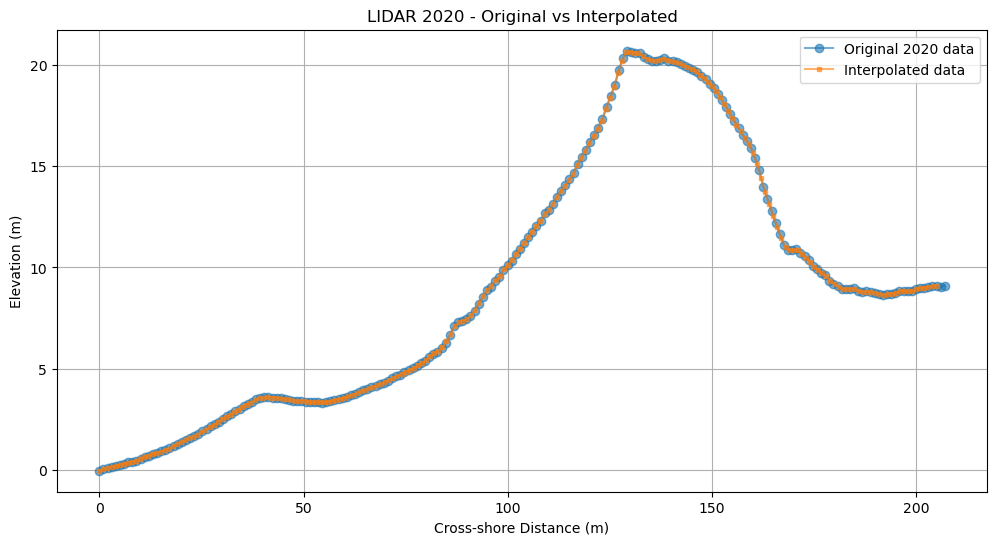

In [3]:
import numpy as np
from scipy.interpolate import interp1d

# Load 2020 LIDAR data
lidar_2020 = pd.read_csv('LIDAR_Olivier/LiDARCarcans2020.txt', sep=r'\s+', header=None)

# Create new x vector (cross-shore) from 0 to 205 with spacing of 1
x_cross_shore = np.arange(0, 206, 1)

# Create interpolation function
f = interp1d(lidar_2020[0], lidar_2020[1], kind='linear', fill_value='extrapolate')

# Interpolate elevation (z) onto new x vector
z_elevation = f(x_cross_shore)

# Display results
print(f"Original data shape: {lidar_2020.shape}")
print(f"New interpolated data length: {len(z_elevation)}")
print(f"X (cross-shore) range: {x_cross_shore[0]} to {x_cross_shore[-1]}")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(lidar_2020[0], lidar_2020[1], 'o-', label='Original 2020 data', alpha=0.6)
plt.plot(x_cross_shore, z_elevation, 's-', label='Interpolated data', alpha=0.6, markersize=3)
plt.xlabel('Cross-shore Distance (m)')
plt.ylabel('Elevation (m)')
plt.title('LIDAR 2020 - Original vs Interpolated')
plt.legend()
plt.grid(True)
plt.show()


X (cross-shore) matrix shape: (200, 206)
Y (longshore) matrix shape: (200, 206)
Z (elevation) matrix shape: (200, 206)
X range: 0 to 205
Y range: 0 to 199
Z range: -0.05 to 20.66


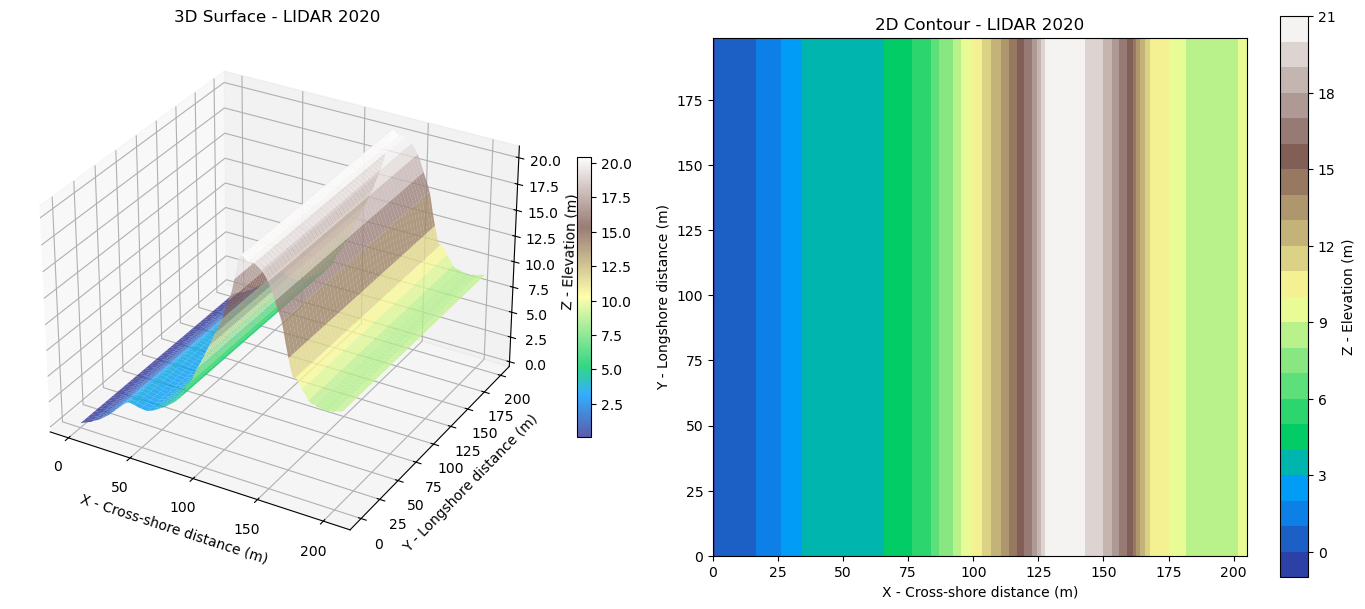

In [4]:
# Create 2D domain
# x_cross_shore already exists from 0 to 205 (206 points)
# Create y direction vector (longshore) from 0 to 200
y_longshore = np.arange(0, 200, 1)  # 200 points

# Create 2D meshgrid for x (cross-shore) and y (longshore) coordinates
X, Y = np.meshgrid(x_cross_shore, y_longshore)

# Extend z_elevation to 2D by repeating it 200 times (one for each row)
Z = np.tile(z_elevation, (200, 1))

# Display dimensions
print(f"X (cross-shore) matrix shape: {X.shape}")
print(f"Y (longshore) matrix shape: {Y.shape}")
print(f"Z (elevation) matrix shape: {Z.shape}")
print(f"X range: {X.min()} to {X.max()}")
print(f"Y range: {Y.min()} to {Y.max()}")
print(f"Z range: {Z.min():.2f} to {Z.max():.2f}")

# Visualize the 2D domain
fig = plt.figure(figsize=(14, 6))

# 3D surface plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='terrain', alpha=0.8)
ax1.set_xlabel('X - Cross-shore distance (m)')
ax1.set_ylabel('Y - Longshore distance (m)')
ax1.set_zlabel('Z - Elevation (m)')
ax1.set_title('3D Surface - LIDAR 2020')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# 2D contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Z, levels=20, cmap='terrain')
ax2.set_xlabel('X - Cross-shore distance (m)')
ax2.set_ylabel('Y - Longshore distance (m)')
ax2.set_title('2D Contour - LIDAR 2020')
ax2.set_aspect('equal')
fig.colorbar(contour, ax=ax2, label='Z - Elevation (m)')

plt.tight_layout()
plt.show()


In [5]:
# Save X, Y, Z to files using numpy savetxt
np.savetxt('LIDAR_2D_X.txt', X)
np.savetxt('LIDAR_2D_Y.txt', Y)
np.savetxt('LIDAR_2D_Z.txt', Z)

# Convert wind data time to seconds from the first timestamp
wind_time_seconds = (wind_data.iloc[:, 0] - wind_data.iloc[0, 0]).dt.total_seconds().values

# Filter wind: set wind speeds to 0 for offshore winds (direction between 0 and 180 degrees)
offshore_mask = (wind_data.iloc[:, 2] >= 0) & (wind_data.iloc[:, 2] <= 180)
wind_speed = wind_data.iloc[:, 1].copy()
wind_speed[offshore_mask] = 0
wind_direction = wind_data.iloc[:, 2].values

# Organize wind data time series in a matrix with three columns:
# Column 1: time (in seconds from start)
# Column 2: wind speed (filtered)
# Column 3: wind direction
wind_matrix = np.column_stack((wind_time_seconds, wind_speed, wind_direction))

# Replace NaN values with 0
wind_matrix = np.nan_to_num(wind_matrix, nan=0.0)

# Save to file
np.savetxt('Wind_Carcans.txt', wind_matrix, fmt='%.6f')
print(f"\nWind matrix saved to Wind_Carcans.txt (offshore winds set to 0, NaN values replaced with 0)")
print(f"Matrix shape: {wind_matrix.shape}")



Wind matrix saved to Wind_Carcans.txt (offshore winds set to 0, NaN values replaced with 0)
Matrix shape: (35351, 3)


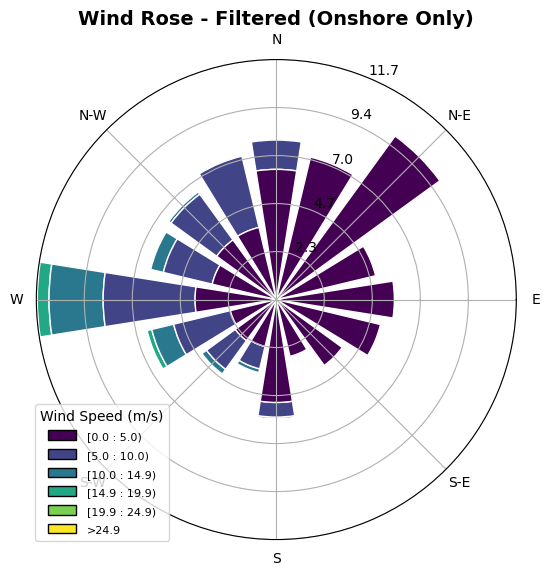

In [6]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

# Plot windrose of filtered wind (onshore only)
fig = plt.figure(figsize=(6, 6))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title='Wind Speed (m/s)')
ax.set_title('Wind Rose - Filtered (Onshore Only)', fontsize=14, fontweight='bold')
plt.show()


In [7]:
# Check if wind_matrix contains only numbers
print(f"Wind matrix data type: {wind_matrix.dtype}")
print(f"Wind matrix shape: {wind_matrix.shape}")
print(f"Contains NaN values: {np.isnan(wind_matrix).any()}")
print(f"Number of NaN values: {np.isnan(wind_matrix).sum()}")
print(f"Contains inf values: {np.isinf(wind_matrix).any()}")
print(f"All finite numbers: {np.isfinite(wind_matrix).all()}")
print(f"\nFirst 10 rows of wind_matrix:")
print(wind_matrix[:10])
print(f"\nLast 10 rows of wind_matrix:")
print(wind_matrix[-10:])


Wind matrix data type: float64
Wind matrix shape: (35351, 3)
Contains NaN values: False
Number of NaN values: 0
Contains inf values: False
All finite numbers: True

First 10 rows of wind_matrix:
[[    0.     0.   110.]
 [ 3600.     0.   130.]
 [ 7200.     0.    90.]
 [10800.     0.    80.]
 [14400.     0.   110.]
 [18000.     0.   110.]
 [21600.     0.   110.]
 [25200.     0.   110.]
 [28800.     0.   110.]
 [32400.     0.   100.]]

Last 10 rows of wind_matrix:
[[1.272276e+08 0.000000e+00 3.000000e+01]
 [1.272312e+08 0.000000e+00 5.000000e+01]
 [1.272348e+08 0.000000e+00 1.300000e+02]
 [1.272384e+08 0.000000e+00 5.000000e+01]
 [1.272420e+08 0.000000e+00 6.000000e+01]
 [1.272456e+08 0.000000e+00 7.000000e+01]
 [1.272492e+08 0.000000e+00 8.000000e+01]
 [1.272528e+08 0.000000e+00 6.000000e+01]
 [1.272564e+08 0.000000e+00 7.000000e+01]
 [1.272600e+08 0.000000e+00 1.100000e+02]]
